In [1]:
"""
In this notebook, we look at the natural scene data, the phase-randomized data, and the Gaussian data and their statistics.

Need to run `mat_file_resave.m`, `select_natural_scenes.py` and `select_natural_scenes_phase_randomized.py` first.
"""

import sys
sys.path.append('../helper/')
sys.path.append('../data/')

import os
import numpy as np
import glob
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import fft
import random
import time
import importlib
from tqdm import tqdm

import helper_functions as hpfn
import moving_edges
import sawtooth_gradient


In [2]:
# specify the folder where the data are saved
data_folder = '/mnt/d/data/'
folder_nat = data_folder + 'panoramic/data_natural_only/'
folder_nat_filtered = data_folder + 'panoramic/data_natural_only_filtered/'
folder_nat_pr = data_folder + 'panoramic/data_natural_only_phase_randomized/'
folder_nat_filtered_pr = data_folder + 'panoramic/data_natural_only_filtered_phase_randomized/'

## Natural scenes

#### An example natural scene image, spacially filtered

The shape of the image is (251, 927).
The shape of the filtered image is (251, 927).
The shape of the resized image is (20, 72).
The shape of the image is (251, 927).
The shape of the filtered image is (251, 927).
The shape of the resized image is (20, 72).


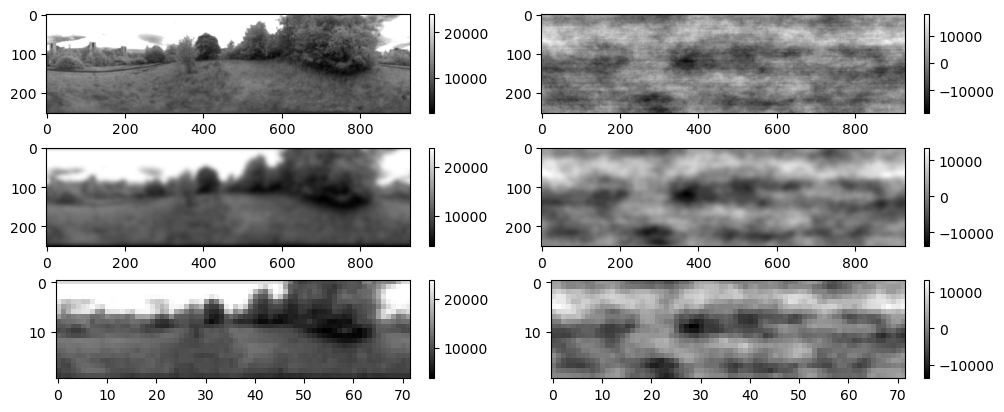

In [4]:
ii = 5
nat_numbers = np.load(data_folder + 'panoramic/natural_scenes_numbers.npy')

fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(3, 2, figure=fig)

# original natural scene
ax = fig.add_subplot(gs[0, 0])
img = np.load(folder_nat + f'natural_{nat_numbers[ii]}.npy')
K_row = img.shape[0] 
K_col = img.shape[1] 
print(f'The shape of the image is {img.shape}.')
im = ax.imshow(img, 'gray')
plt.colorbar(im)


# filtered natural scene
ax = fig.add_subplot(gs[1, 0])
img_filtered = np.load(folder_nat_filtered + f'natural_filtered_{nat_numbers[ii]}.npy')
K_row = img.shape[0] 
K_col = img.shape[1] 
print(f'The shape of the filtered image is {img.shape}.')
im = ax.imshow(img_filtered, 'gray')
plt.colorbar(im)


# resized natural scene
ax = fig.add_subplot(gs[2, 0])
img_resized = hpfn.get_resized(img_filtered)
print(f'The shape of the resized image is {img_resized.shape}.')
im = ax.imshow(img_resized, 'gray')
plt.colorbar(im)


# phase randomized
ax = fig.add_subplot(gs[0, 1])
ii = 3
img = np.load(folder_nat_pr + f'natural_{nat_numbers[ii]}.npy')
K_row = img.shape[0] 
K_col = img.shape[1] 
print(f'The shape of the image is {img.shape}.')
im = ax.imshow(np.real(img), 'gray')
plt.colorbar(im)


# filtered, phase randomized
ax = fig.add_subplot(gs[1, 1])
img_filtered = np.load(folder_nat_filtered_pr + f'natural_filtered_{nat_numbers[ii]}.npy')
K_row = img.shape[0] 
K_col = img.shape[1] 
print(f'The shape of the filtered image is {img.shape}.')
im = ax.imshow(img_filtered, 'gray')
plt.colorbar(im)


# resized, phase randomized
ax = fig.add_subplot(gs[2, 1])
img_resized = hpfn.get_resized(img_filtered)
print(f'The shape of the resized image is {img_resized.shape}.')
im = ax.imshow(img_resized, 'gray')
plt.colorbar(im)

plt.show()


#### Binarized checker board

In [5]:
K_row = 180
K_col = 720

def get_one_checker_board_with_corr(K_row, K_col, scl):
    img = np.zeros((K_row, K_col))
    checker_size = int(K_col / 360 * 5)
    krow = int(K_row / checker_size)
    kcol = int(K_col / checker_size)
    
    for indr in range(krow):
        for indc in range(kcol):
            value = np.sign(np.random.random() - 0.5) * 1
            img[indr*checker_size:(indr+1)*checker_size, indc*checker_size:(indc+1)*checker_size] = value
    img = img * scl
    
    return img
            
            
            

In [6]:
img = get_one_checker_board_with_corr(K_row, K_col, scl=0.57)


The shape of the image is (180, 720).
0.31124974922854726
0.329428900566888


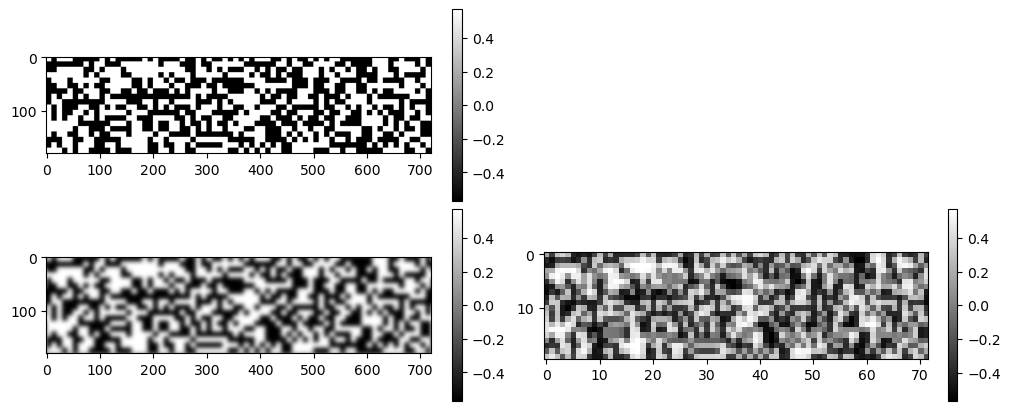

In [7]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)

# phase randomized
ax = fig.add_subplot(gs[0, 0])
print(f'The shape of the image is {img.shape}.')
im = ax.imshow(img, 'gray')
plt.colorbar(im)


# filtered
K_row = img.shape[0] 
K_col = img.shape[1] 
pix_per_deg = K_col / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std
img_filtered = hpfn.get_filtered_spacial(img, pad_size, sigma_for_gaussian)
ax = fig.add_subplot(gs[1, 0])
K_row = img.shape[0] 
K_col = img.shape[1] 
im = ax.imshow(img_filtered, 'gray')
print(img_filtered.std())
plt.colorbar(im)


img_resized = hpfn.get_resized(img_filtered)
ax = fig.add_subplot(gs[1, 1])
im = ax.imshow(img_resized, 'gray')
print(img_resized.std())
plt.colorbar(im)

plt.show()

In [8]:
train_samples = np.load('/mnt/d/data/random_pattern/processed_data_checker/train_samples.npy')
print(train_samples.shape)

(160000, 50, 1, 72)


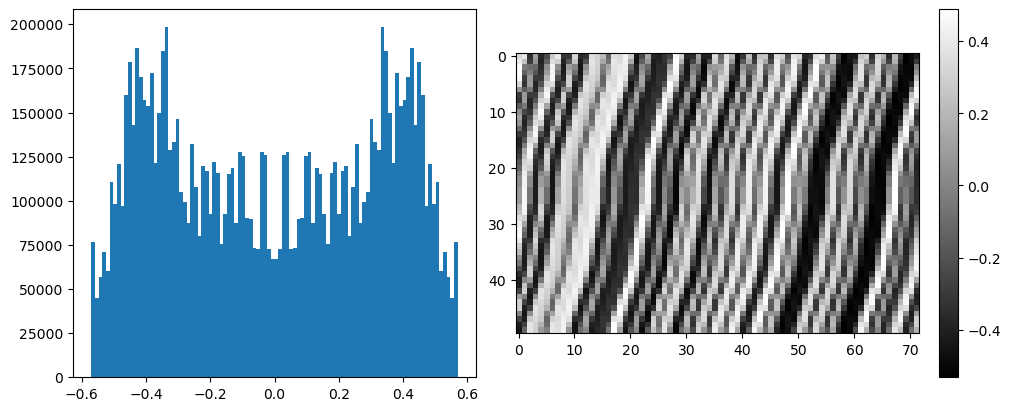

0.3313240869667628


In [9]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.hist(train_samples[:, 40, 0, :].flatten(), 100)


ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(train_samples[100, :, 0, :], 'gray')
plt.colorbar(im)

plt.show()

print(train_samples.std())

In [165]:
train_samples = np.load('/mnt/d/data/random_pattern/processed_data_gaussian/train_samples.npy')
print(train_samples.shape)

(160000, 50, 1, 72)


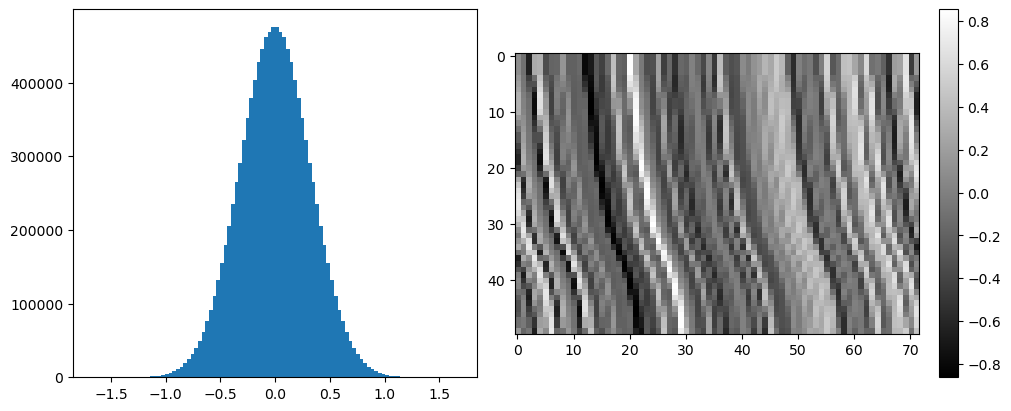

0.3243358145015629


In [168]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.hist(train_samples[:, 1, 0, :].flatten(), 100)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(train_samples[100, :, 0, :], 'gray')
plt.colorbar(im)

plt.show()

print(train_samples.std())

#### Binarized checker board, long spacial correlations

In [10]:
K_row = 180
K_col = 720

def get_one_checker_board_with_corr(K_row, K_col, scl, size):
    img = np.zeros((K_row, K_col))
    checker_size = int(K_col / 360 * size)
    krow = int(K_row / checker_size)
    kcol = int(K_col / checker_size)
    
    for indr in range(krow):
        for indc in range(kcol):
            value = np.sign(np.random.random() - 0.5) * 1
            img[indr*checker_size:(indr+1)*checker_size, indc*checker_size:(indc+1)*checker_size] = value
    img = img * scl
    
    return img
            
            
            

In [11]:
img = get_one_checker_board_with_corr(K_row, K_col, scl=0.3, size=5)
img = img + get_one_checker_board_with_corr(K_row, K_col, scl=0.3, size=45)

The shape of the image is (180, 720).
0.3215400310055224
0.32859084777080083


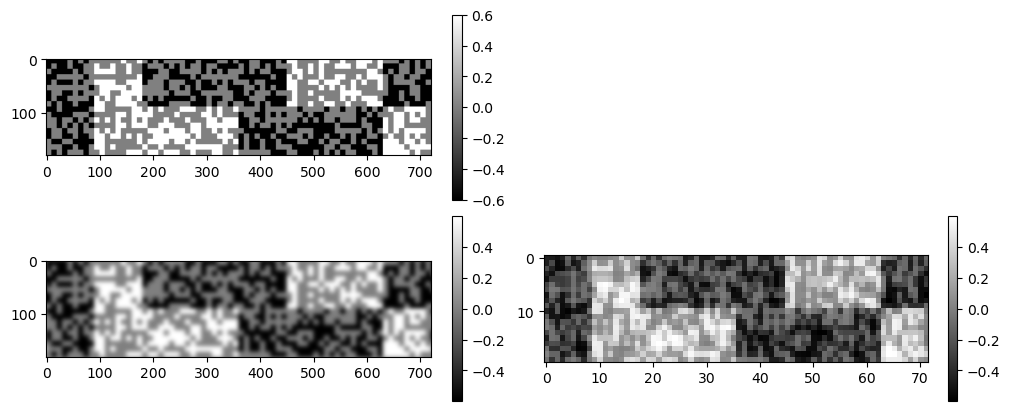

In [12]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)

# phase randomized
ax = fig.add_subplot(gs[0, 0])
print(f'The shape of the image is {img.shape}.')
im = ax.imshow(img, 'gray')
plt.colorbar(im)


# filtered
K_row = img.shape[0] 
K_col = img.shape[1] 
pix_per_deg = K_col / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std
img_filtered = hpfn.get_filtered_spacial(img, pad_size, sigma_for_gaussian)
ax = fig.add_subplot(gs[1, 0])
K_row = img.shape[0] 
K_col = img.shape[1] 
im = ax.imshow(img_filtered, 'gray')
print(img_filtered.std())
plt.colorbar(im)


img_resized = hpfn.get_resized(img_filtered)
ax = fig.add_subplot(gs[1, 1])
im = ax.imshow(img_resized, 'gray')
print(img_resized.std())
plt.colorbar(im)

plt.show()

In [72]:
train_samples = np.load('/mnt/d/data/random_pattern/processed_data_checker_corr/train_samples.npy')
print(train_samples.shape)

(160000, 50, 1, 72)


In [ ]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.hist(train_samples[:, 40, 0, :].flatten(), 100)


ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(train_samples[100, :, 0, :], 'gray')
plt.colorbar(im)

plt.show()

print(train_samples.std())

#### Gaussian scene with longer spatial correlations

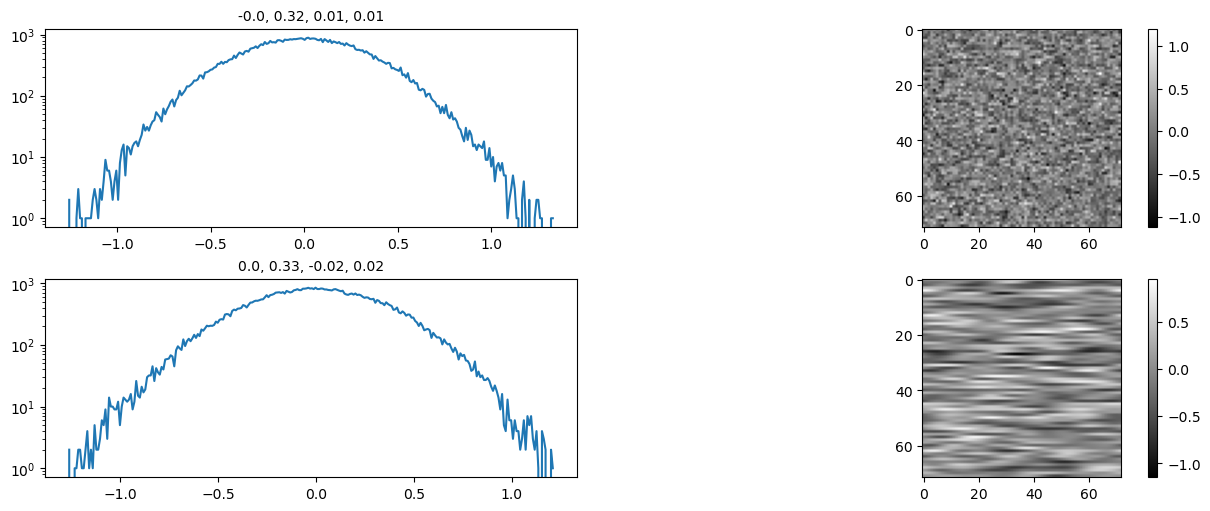

In [13]:
from scipy.stats import normaltest
from scipy import stats

fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)


####### Gaussian
pix_per_deg = 720 / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
img_gaussian = np.random.normal(loc=0., scale=1.25, size=(1000, 720))
img_resized = np.zeros((1000, 72))
for ii in range(1000):
    img_filtered = hpfn.get_filtered_spacial_row(img_gaussian[ii:ii+1], sigma_for_gaussian)
    img_resized[ii] = hpfn.get_resized(img_filtered, n_row=1)
img_resized2 = img_resized.flatten()
hist, bin_centers = hpfn.get_hist(img_resized2)
test_res = normaltest(img_resized2)
ax = fig.add_subplot(gs[0, 0])
ax.plot(bin_centers, hist, alpha=1.)
ax.set_yscale('log')

mean1 = np.round(np.array(img_resized2).mean(), 2)
std1 = np.round(np.array(img_resized2).std(), 2)
skew1 = np.round(skew(np.array(img_resized2)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized2)), 2)
# ax.set_title([np.round(test_res.statistic, 3), np.round(test_res.pvalue, 6)])
ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(img_resized[:72], 'gray')
plt.colorbar(im)


####### Gaussian
pix_per_deg = 720 / 360
FWHM = 50 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
img_gaussian = np.random.normal(loc=0., scale=4, size=(1000, 720))
img_resized = np.zeros((1000, 72))
for ii in range(1000):
    img_filtered = hpfn.get_filtered_spacial_row(img_gaussian[ii:ii+1], sigma_for_gaussian)
    img_resized[ii] = hpfn.get_resized(img_filtered, n_row=1)
img_resized2 = img_resized.flatten()
hist, bin_centers = hpfn.get_hist(img_resized2)
test_res = normaltest(img_resized2)
ax = fig.add_subplot(gs[1, 0])
ax.plot(bin_centers, hist, alpha=1.)
ax.set_yscale('log')

mean1 = np.round(np.array(img_resized2).mean(), 2)
std1 = np.round(np.array(img_resized2).std(), 2)
skew1 = np.round(skew(np.array(img_resized2)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized2)), 2)
# ax.set_title([np.round(test_res.statistic, 3), np.round(test_res.pvalue, 6)])
ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)

ax = fig.add_subplot(gs[1, 1])
im = ax.imshow(img_resized[:72], 'gray')
plt.colorbar(im)


plt.show()


In [8]:
test_samples = np.load('/mnt/d/data/random_pattern/processed_data_gaussian_corr/test_samples.npy')
print(test_samples.shape)

(40000, 50, 1, 72)


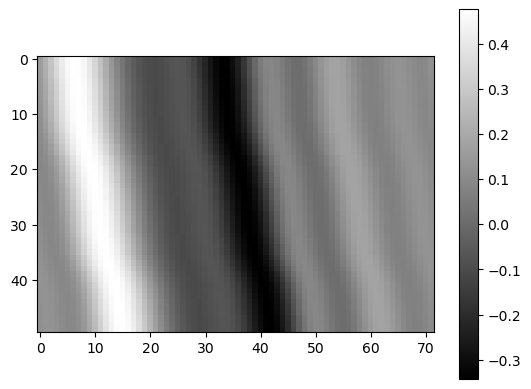

In [11]:
plt.imshow(test_samples[1, :, 0, :], 'gray')
plt.colorbar()
plt.show()


Text(0.5, 1.0, '[0.259, 0.878363]')

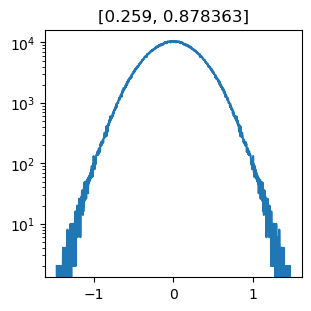

In [16]:
fig = plt.figure(figsize=(3, 3), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)


####### Gaussian
img_resized2 = test_samples[:, 0, 0, :].flatten()
hist, bin_centers = hpfn.get_hist(img_resized2)
test_res = normaltest(img_resized2)
ax = fig.add_subplot(gs[0, 0])
ax.plot(bin_centers, hist, alpha=1.)
ax.set_yscale('log')

mean1 = np.round(np.array(img_resized2).mean(), 2)
std1 = np.round(np.array(img_resized2).std(), 2)
skew1 = np.round(skew(np.array(img_resized2)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized2)), 2)
ax.set_title([np.round(test_res.statistic, 3), np.round(test_res.pvalue, 6)])
# ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)




#### Truncated Cauchy distribution

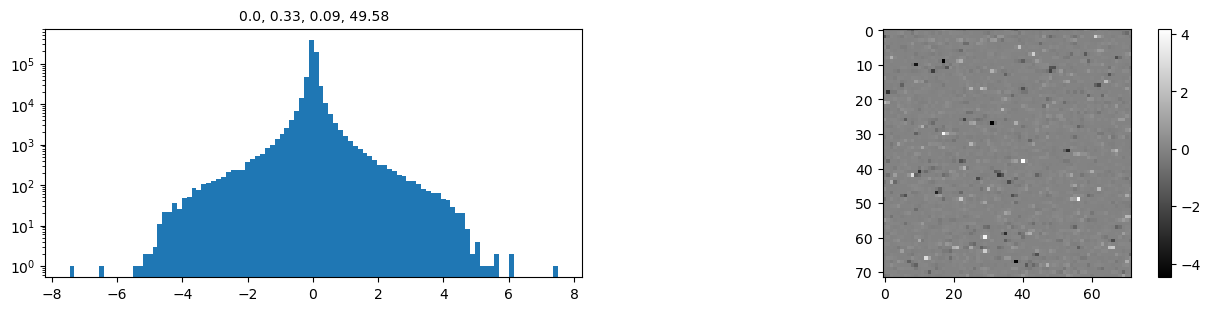

In [20]:
from scipy.stats import normaltest
from scipy import stats


fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

scl = 0.05
####### Truncated Cauchy
pix_per_deg = 720 / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
img_cauchy = stats.cauchy.rvs(size=10000*720*2, scale=scl)
img_cauchy = img_cauchy[abs(img_cauchy)<=50]
img_cauchy = img_cauchy[:int(10000*720)].reshape((10000, 720))
img_resized = np.zeros((10000, 72))
for ii in range(10000):
    img_filtered = hpfn.get_filtered_spacial_row(img_cauchy[ii:ii+1], sigma_for_gaussian)
    img_resized[ii] = hpfn.get_resized(img_filtered, n_row=1)
img_resized2 = img_resized.flatten()
ax = fig.add_subplot(gs[0, 0])
ax.hist(img_resized2, 100)
ax.set_yscale('log')


mean1 = np.round(np.array(img_resized2).mean(), 2)
std1 = np.round(np.array(img_resized2).std(), 2)
skew1 = np.round(skew(np.array(img_resized2)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized2)), 2)
ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(img_resized[:72], 'gray')
plt.colorbar(im)


plt.show()

In [15]:
test_samples = np.load('/mnt/d/data/random_pattern/processed_data_cauchy/test_samples.npy')
print(test_samples.shape)

(40000, 50, 1, 72)


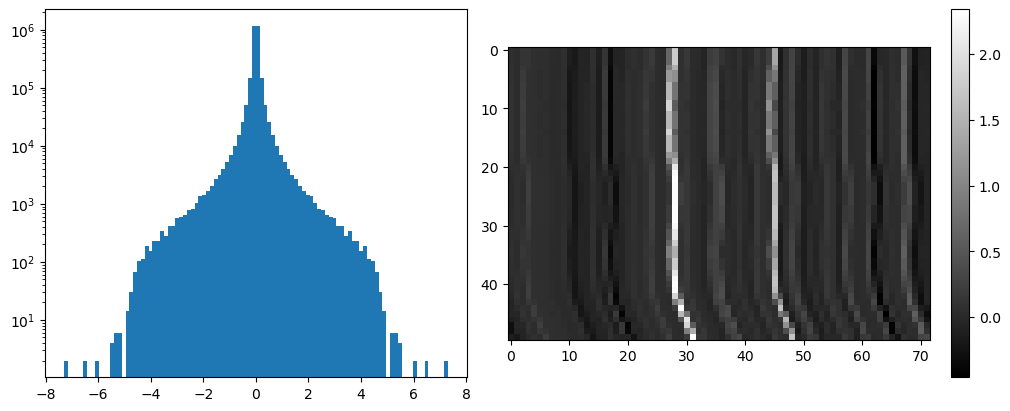

0.3281691123998628


In [17]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.hist(test_samples[:, 40, 0, :].flatten(), 100)
ax.set_yscale('log')


ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(test_samples[100, :, 0, :], 'gray')
plt.colorbar(im)

plt.show()

print(test_samples.std())

#### Laplace distribution

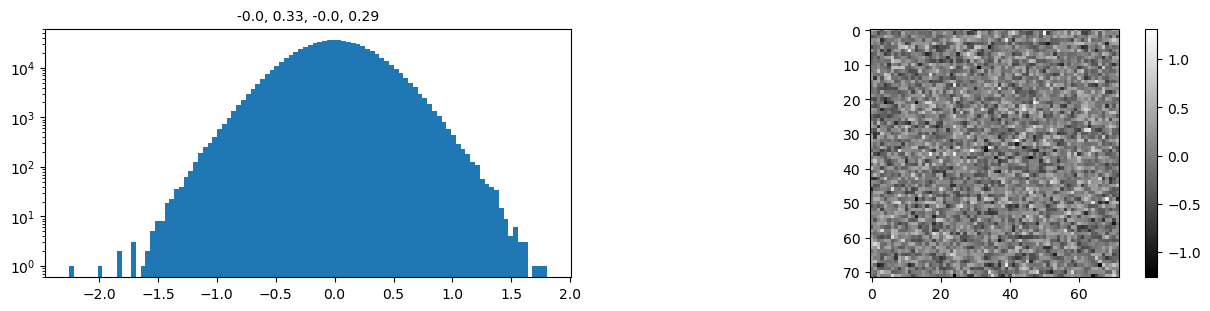

In [137]:
from scipy.stats import normaltest
from scipy import stats


fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

scl = 0.9
####### Truncated laplace
pix_per_deg = 720 / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
img_laplace = stats.laplace.rvs(size=10000*720*2, scale=scl)
# img_laplace = img_laplace[abs(img_laplace)<=50]
img_laplace = img_laplace[:int(10000*720)].reshape((10000, 720))
img_resized = np.zeros((10000, 72))
for ii in range(10000):
    img_filtered = hpfn.get_filtered_spacial_row(img_laplace[ii:ii+1], sigma_for_gaussian)
    img_resized[ii] = hpfn.get_resized(img_filtered, n_row=1)
img_resized2 = img_resized.flatten()
ax = fig.add_subplot(gs[0, 0])
ax.hist(img_resized2, 100)
ax.set_yscale('log')


mean1 = np.round(np.array(img_resized2).mean(), 2)
std1 = np.round(np.array(img_resized2).std(), 2)
skew1 = np.round(skew(np.array(img_resized2)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized2)), 2)
ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(img_resized[:72], 'gray')
plt.colorbar(im)


plt.show()

#### Natural and inverted combined

In [30]:
train_samples = np.load('/mnt/d/data/panoramic/processed_data_natural/train_test_wide_field/train_samples.npy')
print(train_samples.shape)

train_targets = np.load('/mnt/d/data/panoramic/processed_data_natural/train_test_wide_field/train_targets.npy')
print(train_targets.shape)

(144000, 50, 1, 72)
(144000, 1)


In [27]:
# train_samples[72000:] = -train_samples[:72000]
train_samples[::2] = -train_samples[::2]

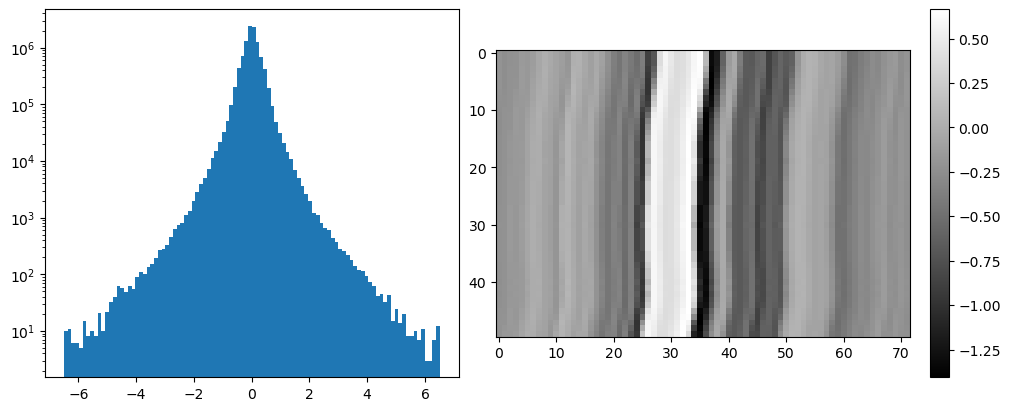

0.33409474186496796


In [28]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.hist(train_samples[:, 40, 0, :].flatten(), 100)
ax.set_yscale('log')


ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(train_samples[100, :, 0, :], 'gray')
plt.colorbar(im)

plt.show()

print(train_samples.std())

#### Natural, true left right symmetry

In [31]:
train_samples = np.load('/mnt/d/data/panoramic/processed_data_natural/train_test_wide_field/train_samples.npy')
print(train_samples.shape)

train_targets = np.load('/mnt/d/data/panoramic/processed_data_natural/train_test_wide_field/train_targets.npy')
print(train_targets.shape)

(144000, 50, 1, 72)
(144000, 1)


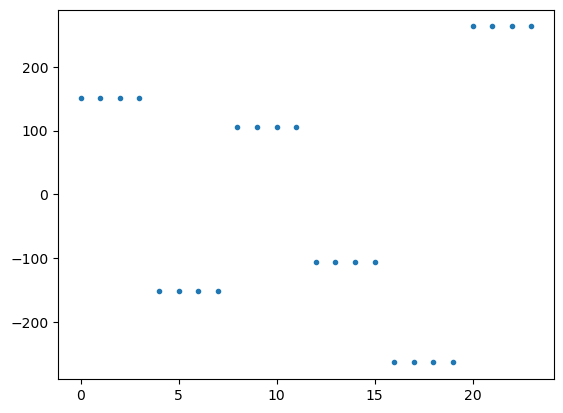

In [35]:
plt.plot(train_targets[:24, 0], '.')
plt.show()

In [36]:
train_samples[1::2] = train_samples[::2, :, :, ::-1]
train_targets[1::2] = -train_targets[::2]

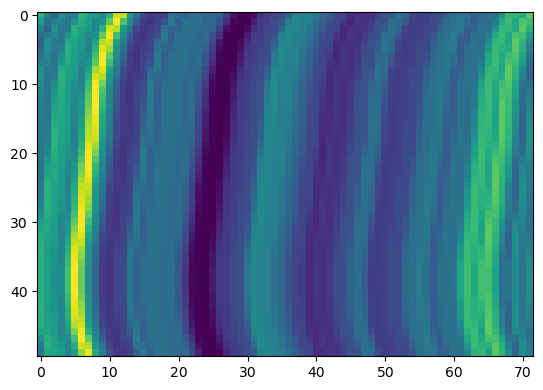

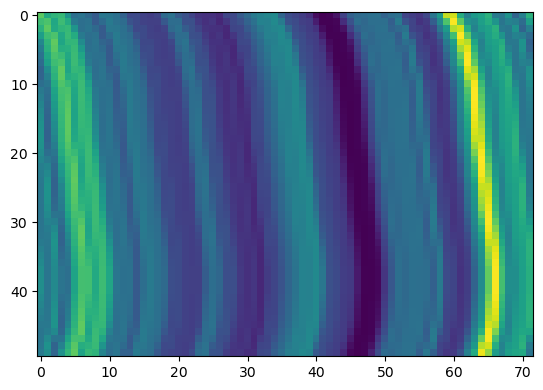

In [37]:
plt.imshow(train_samples[0].squeeze())
plt.show()

plt.imshow(train_samples[1].squeeze())
plt.show()

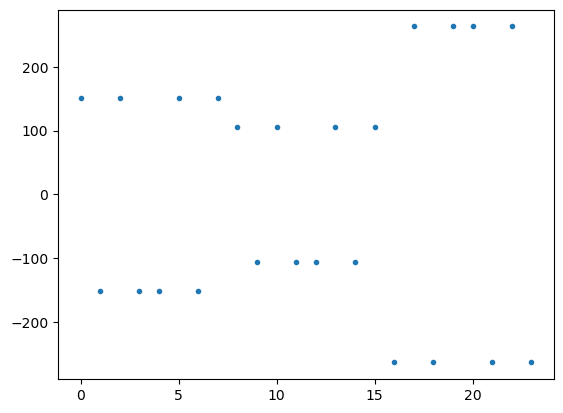

In [38]:
plt.plot(train_targets[:24, 0], '.')
plt.show()

#### Distributions of the natural scene

In [11]:
raw_pixel_collect = []
raw_pixel_collect_filtered = []
contrast_collect_30deg = []
nat_numbers = np.load('/mnt/d/data/panoramic/natural_scenes_numbers.npy')

for ii in tqdm(range(len(nat_numbers))):
    img = np.load(folder_nat + f'natural_{nat_numbers[ii]}.npy')
    K_row = img.shape[0] 
    K_col = img.shape[1] 
    
    raw_pixel_collect.extend(img.flatten())

    # Spacial filtering
    pix_per_deg = K_col / 360
    FWHM = 5 # in degree
    sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
    pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std
    img_filtered = hpfn.get_filtered_spacial(img, pad_size, sigma_for_gaussian)
    raw_pixel_collect_filtered.extend(img_filtered.flatten())
    
    # resizing
    img_resized = hpfn.get_resized(img_filtered)

    # contrast
    scope = '30deg'
    img_contrast = hpfn.get_contrast(img_resized.reshape((1, )+img_resized.shape), scope)
    contrast_collect_30deg.extend(img_contrast.flatten())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:06<00:00, 38.59it/s]


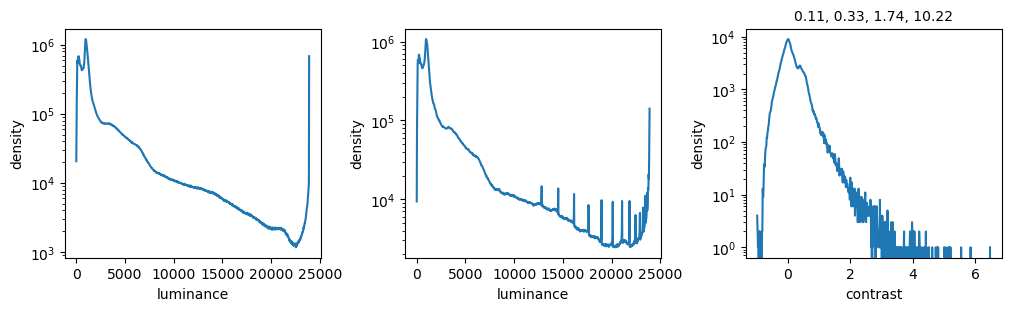

In [12]:
fig = plt.figure(figsize=(10, 3), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig)

####### raw pixel
hist, bin_centers = hpfn.get_hist(np.array(raw_pixel_collect))
ax = fig.add_subplot(gs[0, 0])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('luminance')
ax.set_ylabel('density')

####### raw pixel, filtered
hist, bin_centers = hpfn.get_hist(np.array(raw_pixel_collect_filtered))
ax = fig.add_subplot(gs[0, 1])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('luminance')
ax.set_ylabel('density')

####### contrast
hist, bin_centers = hpfn.get_hist(np.array(contrast_collect_30deg))
mean1 = np.round(np.array(contrast_collect_30deg).mean(), 2)
std1 = np.round(np.array(contrast_collect_30deg).std(), 2)
skew1 = np.round(skew(np.array(contrast_collect_30deg)), 2)
kurtosis1 = np.round(kurtosis(np.array(contrast_collect_30deg)), 2)

ax = fig.add_subplot(gs[0, 2])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('contrast')
ax.set_ylabel('density')
ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)


plt.show()

#### Distributions of the phase randomized and Gaussian

In [19]:
pixel_collect_pr = []
pixel_collect_filtered_pr = []
pixel_collect_resized_pr = []
normalized_collect_pr = []
nat_numbers = np.load('/mnt/d/data/panoramic/natural_scenes_numbers.npy')

for ii in tqdm(range(len(nat_numbers))):
    img = np.load(folder_nat + f'natural_{nat_numbers[ii]}.npy')
    K_row = img.shape[0] 
    K_col = img.shape[1] 

    # phase randomized
    img_ifft = hpfn.get_phase_randomized2(img, delete_zero_freq=True)
    pixel_collect_pr.extend(np.real(img_ifft.flatten()))

    # Spacial filtering
    pix_per_deg = K_col / 360
    FWHM = 5 # in degree
    sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
    pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std
    img_filtered = hpfn.get_filtered_spacial(np.real(img_ifft), pad_size, sigma_for_gaussian)
    pixel_collect_filtered_pr.extend(img_filtered)

    # resizing
    img_resized = hpfn.get_resized(img_filtered)
    pixel_collect_resized_pr.extend(img_resized.flatten())
        
    # normalization, using 0.33
    img_contrast = img_resized / img_resized.flatten().std() * 0.33
    
    normalized_collect_pr.extend(img_contrast.flatten())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:17<00:00, 13.44it/s]


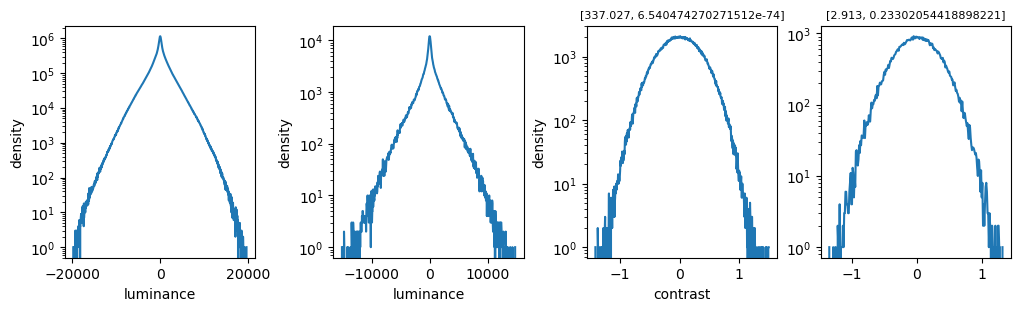

In [22]:
from scipy.stats import normaltest
from scipy import stats

fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = GridSpec(1, 5, figure=fig)


####### phase randomized
hist, bin_centers = hpfn.get_hist(np.array(pixel_collect_pr))

ax = fig.add_subplot(gs[0, 0])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('luminance')
ax.set_ylabel('density')


####### phase randomized, filtered, resized
hist, bin_centers = hpfn.get_hist(np.array(pixel_collect_resized_pr))

ax = fig.add_subplot(gs[0, 1])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('luminance')
ax.set_ylabel('density')


####### phase randomized, filtered, resized, normalized
hist, bin_centers = hpfn.get_hist(np.array(normalized_collect_pr))
mean1 = np.round(np.array(normalized_collect_pr).mean(), 2)
std1 = np.round(np.array(normalized_collect_pr).std(), 2)
skew1 = np.round(skew(np.array(normalized_collect_pr)), 2)
kurtosis1 = np.round(kurtosis(np.array(normalized_collect_pr)), 2)
test_res = normaltest(normalized_collect_pr)
ax = fig.add_subplot(gs[0, 2])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('contrast')
ax.set_ylabel('density')
ax.set_title([np.round(test_res.statistic, 3), test_res.pvalue], fontsize=8)
# ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)


####### Gaussian
pix_per_deg = 720 / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
img_gaussian = np.random.normal(loc=0., scale=1.25, size=(1000, 720))
img_resized = np.zeros((1000, 72))
for ii in range(1000):
    img_filtered = hpfn.get_filtered_spacial_row(img_gaussian[ii:ii+1], sigma_for_gaussian)
    img_resized[ii] = hpfn.get_resized(img_filtered, n_row=1)
img_resized = img_resized.flatten()
hist, bin_centers = hpfn.get_hist(img_resized)
test_res = normaltest(img_resized)
ax = fig.add_subplot(gs[0, 3])
ax.plot(bin_centers, hist, alpha=1.)
ax.set_yscale('log')

mean1 = np.round(np.array(img_resized).mean(), 2)
std1 = np.round(np.array(img_resized).std(), 2)
skew1 = np.round(skew(np.array(img_resized)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized)), 2)
ax.set_title([np.round(test_res.statistic, 3), test_res.pvalue], fontsize=8)
# ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)


plt.show()



In [1]:
train_samples = np.load('/mnt/d/data/panoramic/processed_data_natural_phase_randomized/train_test_wide_field/test_samples.npy')
print(train_samples.shape)

NameError: name 'np' is not defined

0.0, 0.33, 0.0, -0.17


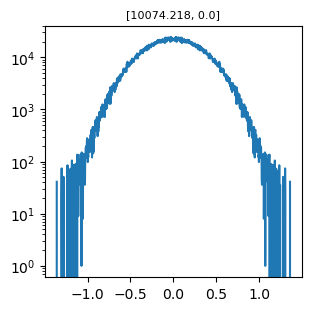

In [29]:
fig = plt.figure(figsize=(3, 3), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)


####### Gaussian
img_resized2 = test_samples[:, 0, 0, :].flatten()
hist, bin_centers = hpfn.get_hist(img_resized2)
test_res = normaltest(img_resized2)
ax = fig.add_subplot(gs[0, 0])
ax.plot(bin_centers, hist, alpha=1.)
ax.set_yscale('log')

mean1 = np.round(np.array(img_resized2).mean(), 2)
std1 = np.round(np.array(img_resized2).std(), 2)
skew1 = np.round(skew(np.array(img_resized2)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized2)), 2)
ax.set_title([np.round(test_res.statistic, 3), test_res.pvalue], fontsize=8)
print(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1))


#### Single image

In [159]:
rand_type = 'uniform'

pixel_collect_pr = []
pixel_collect_filtered_pr = []
pixel_collect_resized_pr = []
normalized_collect_pr = []

nat_numbers = np.load('/mnt/d/data/panoramic/natural_scenes_numbers.npy')
ii = 5
img = np.load(folder_nat + f'natural_{nat_numbers[ii]}.npy')
K_row = img.shape[0] 
K_col = img.shape[1] 

# phase randomized
img_ifft = hpfn.get_phase_randomized(img, rand_type=rand_type , delete_zero_freq=True)
pixel_collect_pr.extend(np.real(img_ifft.flatten()))

# Spacial filtering
pix_per_deg = K_col / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std
img_filtered = hpfn.get_filtered_spacial(np.real(img_ifft), pad_size, sigma_for_gaussian)
pixel_collect_filtered_pr.extend(img_filtered)

# resizing
img_resized = hpfn.get_resized(img_filtered)
pixel_collect_resized_pr.extend(img_resized.flatten())

# normalization, using 0.33
img_contrast = img_resized / img_resized.flatten().std() * 0.33

normalized_collect_pr.extend(img_contrast.flatten())

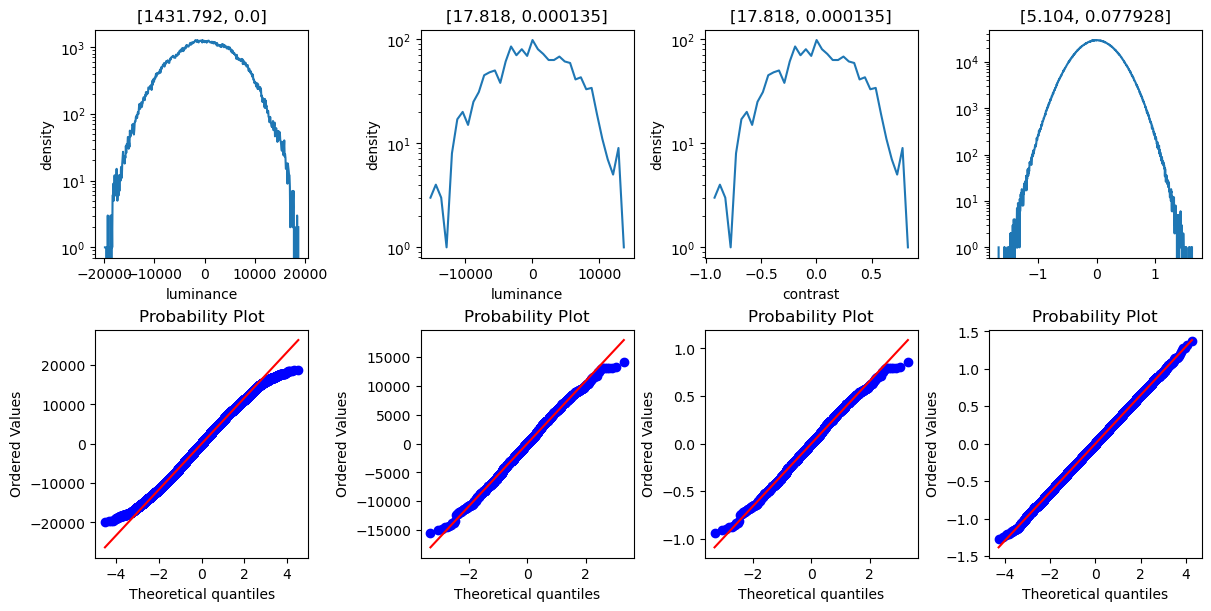

In [164]:
from scipy.stats import normaltest
from scipy import stats

fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = GridSpec(2, 4, figure=fig)


####### phase randomized
hist, bin_centers = hpfn.get_hist(np.array(pixel_collect_pr))
test_res = normaltest(pixel_collect_pr)
ax = fig.add_subplot(gs[0, 0])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('luminance')
ax.set_ylabel('density')
ax.set_title([np.round(test_res.statistic, 3), np.round(test_res.pvalue, 6)])

ax = fig.add_subplot(gs[1, 0])
stats.probplot(pixel_collect_pr, dist='norm', plot=ax)



####### phase randomized, filtered, resized
hist, bin_centers = hpfn.get_hist(np.array(pixel_collect_resized_pr))
test_res = normaltest(pixel_collect_resized_pr)
ax = fig.add_subplot(gs[0, 1])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('luminance')
ax.set_ylabel('density')
ax.set_title([np.round(test_res.statistic, 3), np.round(test_res.pvalue, 6)])

ax = fig.add_subplot(gs[1, 1])
stats.probplot(pixel_collect_resized_pr, dist='norm', plot=ax)


####### phase randomized, filtered, resized, normalized
hist, bin_centers = hpfn.get_hist(np.array(normalized_collect_pr))
mean1 = np.round(np.array(normalized_collect_pr).mean(), 2)
std1 = np.round(np.array(normalized_collect_pr).std(), 2)
skew1 = np.round(skew(np.array(normalized_collect_pr)), 2)
kurtosis1 = np.round(kurtosis(np.array(normalized_collect_pr)), 2)
test_res = normaltest(normalized_collect_pr)
ax = fig.add_subplot(gs[0, 2])
ax.plot(bin_centers, hist, alpha=1.)
# plt.xlim([-100, 100])
ax.set_yscale('log')
ax.set_xlabel('contrast')
ax.set_ylabel('density')
ax.set_title([np.round(test_res.statistic, 3), np.round(test_res.pvalue, 6)])
# ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)

ax = fig.add_subplot(gs[1, 2])
stats.probplot(normalized_collect_pr, dist='norm', plot=ax)


####### Gaussian
pix_per_deg = 720 / 360
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
img_gaussian = np.random.normal(loc=0., scale=1.25, size=(100000, 720))
img_resized = np.zeros((100000, 72))
for ii in range(100000):
    img_filtered = hpfn.get_filtered_spacial_row(img_gaussian[ii:ii+1], sigma_for_gaussian)
    img_resized[ii] = hpfn.get_resized(img_filtered, n_row=1)
img_resized = img_resized.flatten()
hist, bin_centers = hpfn.get_hist(img_resized)
test_res = normaltest(img_resized)
ax = fig.add_subplot(gs[0, 3])
ax.plot(bin_centers, hist, alpha=1.)
ax.set_yscale('log')

mean1 = np.round(np.array(img_resized).mean(), 2)
std1 = np.round(np.array(img_resized).std(), 2)
skew1 = np.round(skew(np.array(img_resized)), 2)
kurtosis1 = np.round(kurtosis(np.array(img_resized)), 2)
ax.set_title([np.round(test_res.statistic, 3), np.round(test_res.pvalue, 6)])
# ax.set_title(str(mean1) + ', ' + str(std1) + ', ' + str(skew1) + ', ' + str(kurtosis1), fontsize=10)

ax = fig.add_subplot(gs[1, 3])
stats.probplot(img_resized[::100], dist='norm', plot=ax)


plt.show()
